preprocessing

In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def load_and_clean_data(file_path):
    """
    Load the drug review data and perform initial cleaning
    """
    # Load data from Excel file
    df = pd.read_csv("C:\\Users\\elain\\Downloads\\TextAnalytics\\drug_lem.csv")
    
    # Check for missing values
    print("Missing values per column:")
    print(df.isnull().sum())
    
    # Remove any rows with missing values in important columns
    important_columns = ['review', 'rating']
    df_cleaned = df.dropna(subset=important_columns)
    
    # Check if any rows were dropped
    rows_dropped = len(df) - len(df_cleaned)
    print(f"\nRows dropped due to missing values in important columns: {rows_dropped}")
    
    # Fill missing values in remaining columns (if any)
    df_cleaned.fillna('', inplace=True)
    
    # Display basic information
    print("\nBasic information:")
    print(f"Number of reviews: {len(df_cleaned)}")
    print(f"Columns: {df_cleaned.columns.tolist()}")
    
    return df_cleaned

def preprocess_text(text):
    """
    Preprocess the review text:
    - Convert to lowercase
    - Remove special characters
    - Remove numbers
    - Tokenize
    - Remove stopwords
    - Stemming
    """
    # Handle non-string inputs (like NaN)
    if not isinstance(text, str) or pd.isna(text) or text == '':
        return ''  # Return empty string for invalid inputs
    
    try:
        # Initialize stemmer and stopwords
        stemmer = PorterStemmer()
        stop_words = set(stopwords.words('english'))
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and stem
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        
        # Join tokens back into string
        processed_text = ' '.join(tokens)
        
        # Return empty string if processing results in empty string
        if not processed_text or processed_text.isspace():
            return ''
            
        return processed_text
    except Exception as e:
        print(f"Error processing text: {e}")
        return ''  # Return empty string in case of any errors

def create_effectiveness_label(rating):
    """
    Create a label for treatment effectiveness based on rating:
    - Ratings 1-4: Not Effective (0)
    - Ratings 5-6: Moderately Effective (1)
    - Ratings 7-10: Effective (2)
    """
    # Handle invalid ratings
    if pd.isna(rating) or not isinstance(rating, (int, float)):
        return np.nan  # Return NaN for invalid ratings
        
    if rating <= 4:
        return 0  # Not Effective
    elif rating <= 6:
        return 1  # Moderately Effective
    else:
        return 2  # Effective

def prepare_dataset_for_sentiment_analysis(df):
    """
    Prepare the dataset for treatment effectiveness sentiment analysis
    """
    # Create a copy to avoid modifying the original dataframe
    processed_df = df.copy()
    
    # Preprocess review text
    print("Preprocessing review text...")
    processed_df['processed_review'] = processed_df['review'].apply(preprocess_text)
    
    # Create effectiveness labels
    print("Creating effectiveness labels...")
    processed_df['effectiveness'] = processed_df['rating'].apply(create_effectiveness_label)
    
    # Remove rows with empty processed reviews or NaN effectiveness
    empty_reviews = processed_df['processed_review'].apply(lambda x: x == '')
    invalid_effectiveness = processed_df['effectiveness'].isna()
    
    rows_to_drop = empty_reviews | invalid_effectiveness
    rows_dropped = rows_to_drop.sum()
    
    processed_df = processed_df[~rows_to_drop]
    
    print(f"\nRows dropped due to empty processed reviews or invalid ratings: {rows_dropped}")
    
    # Display class distribution
    print("\nEffectiveness class distribution:")
    print(processed_df['effectiveness'].value_counts())
    
    # Final check for NaN values
    print("\nChecking for any remaining NaN values:")
    print(processed_df.isnull().sum())
    
    return processed_df

def split_dataset(df, text_column='processed_review', label_column='effectiveness'):
    """
    Split the dataset into training, validation, and test sets with a 70/15/15 split ratio
    """
    # First split: 85% train+val, 15% test
    train_val_df, test_df = train_test_split(
        df, 
        test_size=0.15, 
        random_state=42, 
        stratify=df[label_column]
    )
    
    # Second split: 70% train, 15% val (from the 85% train+val)
    # This is ~17.6% of the 85% train+val data to get 15% overall
    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=0.176, 
        random_state=42, 
        stratify=train_val_df[label_column]
    )
    
    print(f"\nDataset split complete:")
    print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"Testing set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
    
    # Verify stratification
    print("\nEffectiveness distribution in splits:")
    print("Training set:")
    print(train_df[label_column].value_counts(normalize=True).sort_index() * 100)
    print("Validation set:")
    print(val_df[label_column].value_counts(normalize=True).sort_index() * 100)
    print("Testing set:")
    print(test_df[label_column].value_counts(normalize=True).sort_index() * 100)
    
    return train_df, val_df, test_df

def extract_features(train_df, val_df, test_df, text_column='processed_review'):
    """
    Extract TF-IDF features from preprocessed text
    Important: Fit the vectorizer only on training data
    """
    # Final check for empty strings before vectorization
    for dataset_name, dataset in [("Training", train_df), ("Validation", val_df), ("Testing", test_df)]:
        empty_reviews = dataset[text_column].apply(lambda x: x == '')
        if empty_reviews.any():
            print(f"\nWarning: {empty_reviews.sum()} empty reviews found in {dataset_name} set. Removing them...")
            dataset.drop(dataset[empty_reviews].index, inplace=True)
    
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    
    # Fit and transform training data
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[text_column])
    
    # Transform validation and test data using the fitted vectorizer
    X_val_tfidf = tfidf_vectorizer.transform(val_df[text_column])
    X_test_tfidf = tfidf_vectorizer.transform(test_df[text_column])
    
    print(f"\nFeature extraction complete:")
    print(f"Number of features: {X_train_tfidf.shape[1]}")
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer

def main():
    # File path
    file_path = "C:\\Users\\elain\\Downloads\\TextAnalytics\\drug_lem.csv"
    
    # Load and clean data
    df = load_and_clean_data(file_path)
    
    # Prepare dataset for sentiment analysis
    processed_df = prepare_dataset_for_sentiment_analysis(df)
    
    # Split dataset into train, validation, and test sets
    train_df, val_df, test_df = split_dataset(processed_df)
    
    # Extract features using the TF-IDF vectorizer
    X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer = extract_features(train_df, val_df, test_df)
    
    # Get labels
    y_train = train_df['effectiveness']
    y_val = val_df['effectiveness']
    y_test = test_df['effectiveness']
    
    # Save preprocessed data splits for further analysis
    output_dir = "C:\\Users\\elain\\Downloads\\TextAnalytics"
    train_df.to_csv(f"{output_dir}\\train_drug_reviews2.csv", index=False)
    val_df.to_csv(f"{output_dir}\\val_drug_reviews2.csv", index=False)
    test_df.to_csv(f"{output_dir}\\test_drug_reviews2.csv", index=False)
    
    # Save the combined preprocessed data as well
    processed_df.to_csv(f"{output_dir}\\preprocessed_drug_reviews2.csv", index=False)
    
    print("\nPreprocessing complete. Data has been split and saved to CSV files.")
    
    # Save TF-IDF vectorizer for future use
    import pickle
    with open(f"{output_dir}\\tfidf_vectorizer.pkl", "wb") as f:
        pickle.dump(tfidf_vectorizer, f)
    
    print("TF-IDF vectorizer saved to file.")
    

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Missing values per column:
drugName       0
condition      0
review         0
rating         0
usefulCount    0
dtype: int64

Rows dropped due to missing values in important columns: 0

Basic information:
Number of reviews: 212692
Columns: ['drugName', 'condition', 'review', 'rating', 'usefulCount']
Preprocessing review text...
Creating effectiveness labels...

Rows dropped due to empty processed reviews or invalid ratings: 4

Effectiveness class distribution:
effectiveness
2    140822
0     52943
1     18923
Name: count, dtype: int64

Checking for any remaining NaN values:
drugName            0
condition           0
review              0
rating              0
usefulCount         0
processed_review    0
effectiveness       0
dtype: int64

Dataset split complete:
Training set size: 148966 (70.0%)
Validation set size: 31818 (15.0%)
Testing set size: 31904 (15.0%)

Effectiveness distribution in splits:
Training set:
effectiveness
0    24.892257
1     8.897332
2    66.210410
Name: proporti

Datasets loaded successfully:
Training set shape: (148966, 5000)
Validation set shape: (31818, 5000)
Test set shape: (31904, 5000)

Training Multinomial Naive Bayes...
Multinomial Naive Bayes validation accuracy: 0.7270

Classification Report:
                      precision    recall  f1-score   support

       Not Effective       0.79      0.30      0.44      7920
Moderately Effective       0.00      0.00      0.00      2831
           Effective       0.72      0.98      0.83     21067

            accuracy                           0.73     31818
           macro avg       0.50      0.43      0.42     31818
        weighted avg       0.67      0.73      0.66     31818


Training Logistic Regression...


C:\Users\elain\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\elain\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\elain\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression validation accuracy: 0.7824

Classification Report:
                      precision    recall  f1-score   support

       Not Effective       0.69      0.65      0.67      7920
Moderately Effective       0.42      0.04      0.08      2831
           Effective       0.81      0.93      0.87     21067

            accuracy                           0.78     31818
           macro avg       0.64      0.54      0.54     31818
        weighted avg       0.75      0.78      0.75     31818


Training Linear SVM...


C:\Users\elain\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVM validation accuracy: 0.7808

Classification Report:
                      precision    recall  f1-score   support

       Not Effective       0.68      0.66      0.67      7920
Moderately Effective       0.45      0.02      0.03      2831
           Effective       0.81      0.93      0.87     21067

            accuracy                           0.78     31818
           macro avg       0.65      0.54      0.52     31818
        weighted avg       0.75      0.78      0.74     31818


Training Random Forest...
Random Forest validation accuracy: 0.8853

Classification Report:
                      precision    recall  f1-score   support

       Not Effective       0.94      0.73      0.82      7920
Moderately Effective       1.00      0.56      0.72      2831
           Effective       0.86      0.99      0.92     21067

            accuracy                           0.89     31818
           macro avg       0.93      0.76      0.82     31818
        weighted avg       0.89  

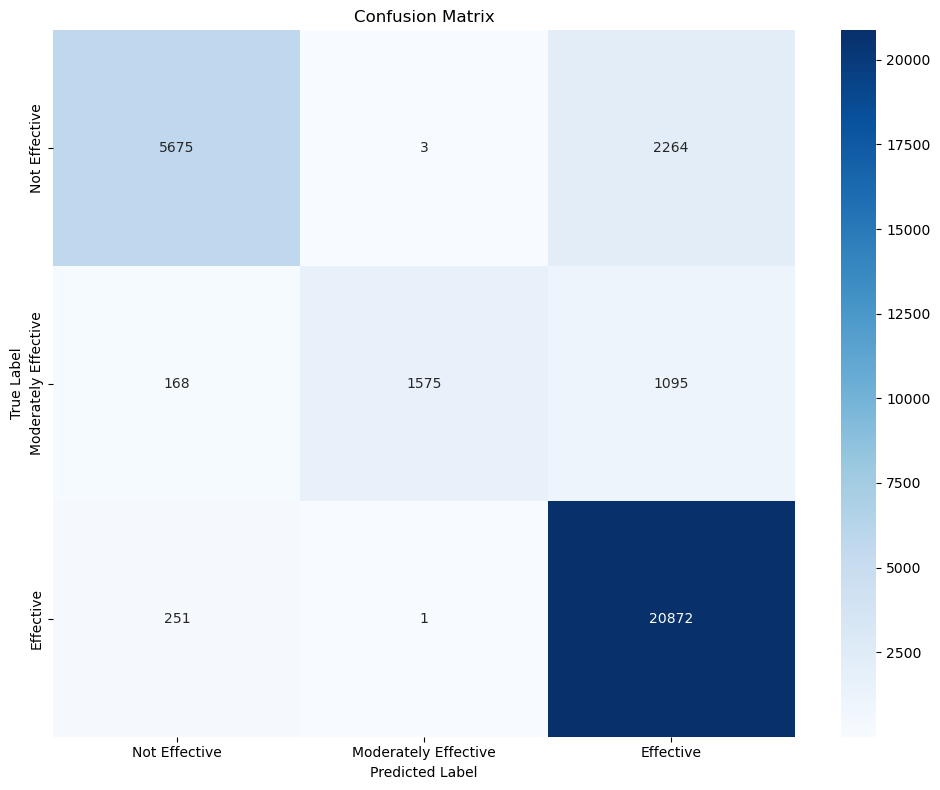

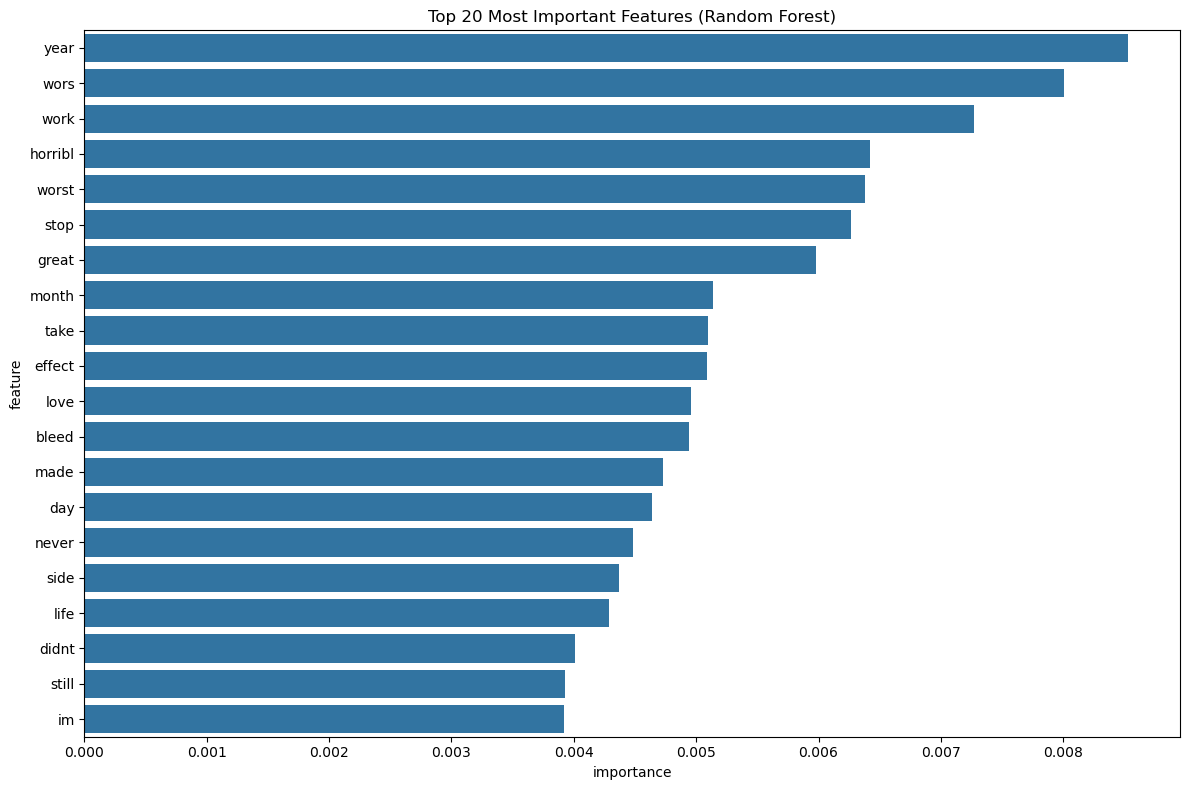


Top 20 most important features:
      feature  importance
4943     year    0.008528
4897     wors    0.008010
4891     work    0.007273
2062  horribl    0.006420
4899    worst    0.006383
4158     stop    0.006264
1882    great    0.005982
2776    month    0.005134
4299     take    0.005097
1383   effect    0.005088
2552     love    0.004960
487     bleed    0.004940
2584     made    0.004731
1076      day    0.004639
2870    never    0.004482
3910     side    0.004373
2467     life    0.004285
1193    didnt    0.004009
4147    still    0.003932
2142       im    0.003918

Total misclassified examples: 3782 (11.85%)

Misclassification by true class:
   True Class  Misclassification Rate (%)
0           0                   28.544447
1           1                   44.503171
2           2                    1.192956

Confusion pattern:
   True Class  Predicted Class  Count
1           0                2   2264
3           1                2   1095
4           2                0    251
2 

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os

def load_datasets(base_dir):
    """
    Load preprocessed datasets from CSV files
    """
    train_df = pd.read_csv(f"{base_dir}/train_drug_reviews2.csv")
    val_df = pd.read_csv(f"{base_dir}/val_drug_reviews2.csv")
    test_df = pd.read_csv(f"{base_dir}/test_drug_reviews2.csv")
    
    # Load TF-IDF vectorizer
    with open(f"{base_dir}/tfidf_vectorizer.pkl", "rb") as f:
        tfidf_vectorizer = pickle.load(f)
    
    # Transform data using the loaded vectorizer
    X_train_tfidf = tfidf_vectorizer.transform(train_df['processed_review'])
    X_val_tfidf = tfidf_vectorizer.transform(val_df['processed_review'])
    X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_review'])
    
    # Get labels
    y_train = train_df['effectiveness']
    y_val = val_df['effectiveness']
    y_test = test_df['effectiveness']
    
    print("Datasets loaded successfully:")
    print(f"Training set shape: {X_train_tfidf.shape}")
    print(f"Validation set shape: {X_val_tfidf.shape}")
    print(f"Test set shape: {X_test_tfidf.shape}")
    
    return X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, tfidf_vectorizer

def train_baseline_models(X_train, y_train, X_val, y_val):
    """
    Train multiple baseline models and compare their performance
    """
    models = {
        'Multinomial Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Linear SVM': LinearSVC(max_iter=10000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        # Predict on validation set
        val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, val_pred)
        
        print(f"{name} validation accuracy: {val_accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, val_pred, 
                                    target_names=['Not Effective', 'Moderately Effective', 'Effective']))
        
        # Save results
        results[name] = {
            'model': model,
            'validation_accuracy': val_accuracy,
            'predictions': val_pred
        }
    
    # Find the best model based on validation accuracy
    best_model_name = max(results, key=lambda k: results[k]['validation_accuracy'])
    print(f"\nBest model: {best_model_name} with validation accuracy: {results[best_model_name]['validation_accuracy']:.4f}")
    
    return results, best_model_name

def optimize_best_model(X_train, y_train, X_val, y_val, best_model_name):
    """
    Optimize the best baseline model using grid search
    """
    if best_model_name == 'Multinomial Naive Bayes':
        model = MultinomialNB()
        param_grid = {
            'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
        }
    elif best_model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42)
        param_grid = {
            'C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['liblinear', 'saga'],
            'max_iter': [1000, 2000]
        }
    elif best_model_name == 'Linear SVM':
        model = LinearSVC(random_state=42)
        param_grid = {
            'C': [0.01, 0.1, 1.0, 10.0],
            'loss': ['hinge', 'squared_hinge'],
            'max_iter': [10000]
        }
    elif best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    else:
        raise ValueError(f"Unsupported model: {best_model_name}")
    
    print(f"\nOptimizing {best_model_name} with Grid Search...")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate on validation set
    val_pred = grid_search.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    
    print(f"Optimized {best_model_name} validation accuracy: {val_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, val_pred, 
                                target_names=['Not Effective', 'Moderately Effective', 'Effective']))
    
    return grid_search.best_estimator_

def evaluate_final_model(best_model, X_test, y_test):
    """
    Evaluate the final model on the test set
    """
    # Predict on test set
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    print(f"\nFinal model test accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_pred, 
                                target_names=['Not Effective', 'Moderately Effective', 'Effective']))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Effective', 'Moderately Effective', 'Effective'],
                yticklabels=['Not Effective', 'Moderately Effective', 'Effective'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return test_accuracy, test_pred

def analyze_feature_importance(best_model, tfidf_vectorizer, model_name):
    """
    Analyze and visualize feature importance for the final model
    """
    # Only works for certain model types
    if model_name in ['Logistic Regression', 'Linear SVM']:
        # Get feature names
        feature_names = tfidf_vectorizer.get_feature_names_out()
        
        # Get coefficients
        if model_name == 'Logistic Regression':
            # For multiclass problem, we take the average magnitude across all classes
            coefficients = np.mean(np.abs(best_model.coef_), axis=0)
        else:  # Linear SVM
            coefficients = np.abs(best_model.coef_[0]) if len(best_model.coef_.shape) > 1 else np.abs(best_model.coef_)
        
        # Create DataFrame for feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
        plt.title(f'Top 20 Most Important Features ({model_name})')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        
        print("\nTop 20 most important features:")
        print(feature_importance.head(20))
        
        return feature_importance
    
    elif model_name == 'Random Forest':
        # Get feature names
        feature_names = tfidf_vectorizer.get_feature_names_out()
        
        # Get feature importances
        importances = best_model.feature_importances_
        
        # Create DataFrame for feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
        plt.title('Top 20 Most Important Features (Random Forest)')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        
        print("\nTop 20 most important features:")
        print(feature_importance.head(20))
        
        return feature_importance
    
    else:
        print(f"\nFeature importance analysis not available for {model_name}.")
        return None

def analyze_misclassifications(test_df, y_test, test_pred, output_dir):
    """
    Analyze misclassified examples to understand model weaknesses
    """
    # Create a copy of test data and add predictions
    analysis_df = test_df.copy()
    analysis_df['predicted_effectiveness'] = test_pred
    analysis_df['misclassified'] = analysis_df['effectiveness'] != analysis_df['predicted_effectiveness']
    
    # Get misclassified examples
    misclassified_df = analysis_df[analysis_df['misclassified']]
    
    print(f"\nTotal misclassified examples: {len(misclassified_df)} ({len(misclassified_df)/len(analysis_df)*100:.2f}%)")
    
    # Analyze misclassifications by true class
    print("\nMisclassification by true class:")
    misclass_by_true = misclassified_df.groupby('effectiveness').size()
    total_by_true = analysis_df.groupby('effectiveness').size()
    misclass_rate = (misclass_by_true / total_by_true * 100).reset_index()
    misclass_rate.columns = ['True Class', 'Misclassification Rate (%)']
    print(misclass_rate)
    
    # Confusion analysis: What class is most often confused with what
    print("\nConfusion pattern:")
    confusion_pattern = misclassified_df.groupby(['effectiveness', 'predicted_effectiveness']).size().reset_index()
    confusion_pattern.columns = ['True Class', 'Predicted Class', 'Count']
    print(confusion_pattern.sort_values('Count', ascending=False))
    
    # Save some misclassified examples for each error type
    misclass_examples = {}
    for true_class in [0, 1, 2]:
        for pred_class in [0, 1, 2]:
            if true_class != pred_class:
                key = f"true_{true_class}_pred_{pred_class}"
                examples = misclassified_df[
                    (misclassified_df['effectiveness'] == true_class) & 
                    (misclassified_df['predicted_effectiveness'] == pred_class)
                ].head(5)
                
                if not examples.empty:
                    misclass_examples[key] = examples
    
    # Save misclassified examples to file
    with open(f"{output_dir}/misclassified_examples.txt", "w", encoding="utf-8") as f:
        for error_type, examples in misclass_examples.items():
            f.write(f"\n\n======= {error_type} =======\n")
            for i, row in examples.iterrows():
                f.write(f"\nDrug: {row['drugName']}\n")
                f.write(f"Condition: {row['condition']}\n")
                f.write(f"Rating: {row['rating']}\n")
                f.write(f"True Effectiveness: {row['effectiveness']}\n")
                f.write(f"Predicted Effectiveness: {row['predicted_effectiveness']}\n")
                f.write(f"Review: {row['review']}\n")
                f.write("-" * 80 + "\n")
    
    print(f"\nMisclassified examples saved to {output_dir}/misclassified_examples.txt")
    
    return misclassified_df

def save_model(best_model, tfidf_vectorizer, output_dir):
    """
    Save the final model and vectorizer
    """
    # Create model directory if it doesn't exist
    os.makedirs(f"{output_dir}/model", exist_ok=True)
    
    # Save model
    with open(f"{output_dir}/model/final_sentiment_model.pkl", "wb") as f:
        pickle.dump(best_model, f)
    
    # Save vectorizer (in case it was modified during optimization)
    with open(f"{output_dir}/model/tfidf_vectorizer_final.pkl", "wb") as f:
        pickle.dump(tfidf_vectorizer, f)
    
    print(f"\nFinal model and vectorizer saved to {output_dir}/model/")

def main():
    # Set the base directory
    base_dir = 'C:\\Users\\elain\\Downloads\\TextAnalytics'
    
    # Load datasets
    X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, tfidf_vectorizer = load_datasets(base_dir)
    
    # Get test dataframe for later analysis (ensure the correct file is used)
    test_df = pd.read_csv(f"{base_dir}/test_drug_reviews.csv")
    
    # Train baseline models
    baseline_results, best_model_name = train_baseline_models(X_train_tfidf, y_train, X_val_tfidf, y_val)
    
    # Retrieve the best model from baseline results
    best_model = baseline_results[best_model_name]['model']
    
    # Optionally, optimize the best model with grid search:
    # best_model = optimize_best_model(X_train_tfidf, y_train, X_val_tfidf, y_val, best_model_name)
    
    # Evaluate final model on test set
    test_accuracy, test_pred = evaluate_final_model(best_model, X_test_tfidf, y_test)
    
    # Analyze feature importance
    feature_importance = analyze_feature_importance(best_model, tfidf_vectorizer, best_model_name)
    
    # Analyze misclassifications
    misclassified_df = analyze_misclassifications(test_df, y_test, test_pred, base_dir)
    
    # Save final model
    save_model(best_model, tfidf_vectorizer, base_dir)
    
    print("\nSentiment analysis model pipeline complete!")
    
if __name__ == "__main__":
    main()
